In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load the dataset
df = pd.read_csv('GOOG.csv')

In [ ]:
# Initial inspection
print(df.head())
print(df.shape)

  symbol                       date   close    high       low    open  \
0   GOOG  2016-06-14 00:00:00+00:00  718.27  722.47  713.1200  716.48   
1   GOOG  2016-06-15 00:00:00+00:00  718.92  722.98  717.3100  719.00   
2   GOOG  2016-06-16 00:00:00+00:00  710.36  716.65  703.2600  714.91   
3   GOOG  2016-06-17 00:00:00+00:00  691.72  708.82  688.4515  708.65   
4   GOOG  2016-06-20 00:00:00+00:00  693.71  702.48  693.4100  698.77   

    volume  adjClose  adjHigh    adjLow  adjOpen  adjVolume  divCash  \
0  1306065    718.27   722.47  713.1200   716.48    1306065      0.0   
1  1214517    718.92   722.98  717.3100   719.00    1214517      0.0   
2  1982471    710.36   716.65  703.2600   714.91    1982471      0.0   
3  3402357    691.72   708.82  688.4515   708.65    3402357      0.0   
4  2082538    693.71   702.48  693.4100   698.77    2082538      0.0   

   splitFactor  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  
(1258, 14)


In [ ]:
# Check unique counts for specified columns
print(df[['symbol', 'divCash', 'splitFactor']].value_counts())

symbol  divCash  splitFactor
GOOG    0.0      1.0            1258
Name: count, dtype: int64


In [ ]:
# Set the index to the date column
df.index = pd.to_datetime(df['date'])

In [ ]:
# Drop unnecessary columns
df.drop(columns=['symbol', 'date', 'divCash', 'splitFactor'], inplace=True)
print(df.head())

                            close    high       low    open   volume  \
date                                                                   
2016-06-14 00:00:00+00:00  718.27  722.47  713.1200  716.48  1306065   
2016-06-15 00:00:00+00:00  718.92  722.98  717.3100  719.00  1214517   
2016-06-16 00:00:00+00:00  710.36  716.65  703.2600  714.91  1982471   
2016-06-17 00:00:00+00:00  691.72  708.82  688.4515  708.65  3402357   
2016-06-20 00:00:00+00:00  693.71  702.48  693.4100  698.77  2082538   

                           adjClose  adjHigh    adjLow  adjOpen  adjVolume  
date                                                                        
2016-06-14 00:00:00+00:00    718.27   722.47  713.1200   716.48    1306065  
2016-06-15 00:00:00+00:00    718.92   722.98  717.3100   719.00    1214517  
2016-06-16 00:00:00+00:00    710.36   716.65  703.2600   714.91    1982471  
2016-06-17 00:00:00+00:00    691.72   708.82  688.4515   708.65    3402357  
2016-06-20 00:00:00+00:00    693.

In [ ]:
# Check for duplicates and missing values
print("Duplicates: ", df.duplicated().sum())
print("Missing values:\n", df.isnull().sum())
print(df.info())

Duplicates:  0
Missing values:
 close        0
high         0
low          0
open         0
volume       0
adjClose     0
adjHigh      0
adjLow       0
adjOpen      0
adjVolume    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2016-06-14 00:00:00+00:00 to 2021-06-11 00:00:00+00:00
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   close      1258 non-null   float64
 1   high       1258 non-null   float64
 2   low        1258 non-null   float64
 3   open       1258 non-null   float64
 4   volume     1258 non-null   int64  
 5   adjClose   1258 non-null   float64
 6   adjHigh    1258 non-null   float64
 7   adjLow     1258 non-null   float64
 8   adjOpen    1258 non-null   float64
 9   adjVolume  1258 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 108.1 KB
None


In [ ]:
# Prepare the dataframe for sliding window
df1 = df[['close']].copy()

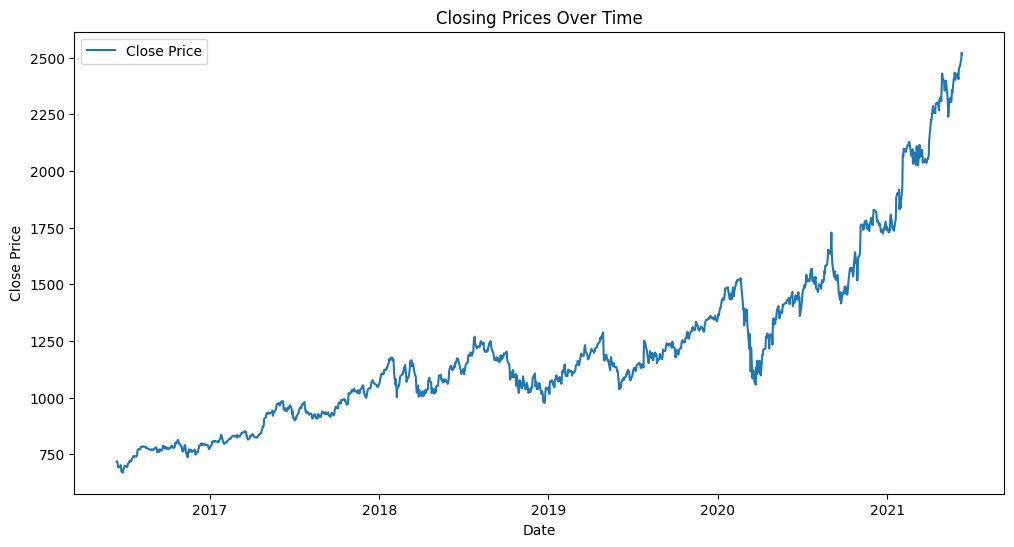

In [ ]:
# Plot the closing prices
plt.figure(figsize=(12, 6))
plt.plot(df1.index, df1['close'], label='Close Price')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# Function to create sliding window data
def create_sliding_window_data(df, window_size, target_column):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i+window_size].values.flatten())
        y.append(df.iloc[i+window_size][target_column])

    X = np.array(X)
    y = np.array(y)

    # Combine X and y into a single DataFrame
    feature_columns = [f"{col}_t-{t}" for t in range(window_size, 0, -1) for col in df.columns]
    columns = feature_columns + [f"target_t+{window_size}"]
    data = np.hstack((X, y.reshape(-1, 1)))
    sliding_window_df = pd.DataFrame(data, columns=columns)

    return sliding_window_df

In [ ]:
# Define parameters
window_size = 60
target_column = 'close'

# Create sliding window data
sliding_window_df = create_sliding_window_data(df1, window_size, target_column)
sliding_window_df.index = pd.date_range(start=df1.index[window_size], periods=len(sliding_window_df), freq='B')


In [ ]:
print("Sliding Window DataFrame:")
print(sliding_window_df.head())

Sliding Window DataFrame:
                           close_t-60  close_t-59  close_t-58  close_t-57  \
2016-09-08 00:00:00+00:00      718.27      718.92      710.36      691.72   
2016-09-09 00:00:00+00:00      718.92      710.36      691.72      693.71   
2016-09-12 00:00:00+00:00      710.36      691.72      693.71      695.94   
2016-09-13 00:00:00+00:00      691.72      693.71      695.94      697.46   
2016-09-14 00:00:00+00:00      693.71      695.94      697.46      701.87   

                           close_t-56  close_t-55  close_t-54  close_t-53  \
2016-09-08 00:00:00+00:00      693.71      695.94      697.46      701.87   
2016-09-09 00:00:00+00:00      695.94      697.46      701.87      675.22   
2016-09-12 00:00:00+00:00      697.46      701.87      675.22      668.26   
2016-09-13 00:00:00+00:00      701.87      675.22      668.26      680.04   
2016-09-14 00:00:00+00:00      675.22      668.26      680.04      684.11   

                           close_t-52  close_t-5

In [ ]:
# Training data
X_train = sliding_window_df.drop(columns=[f'target_t+{window_size}']).values
Y_train = sliding_window_df[f'target_t+{window_size}'].values

In [ ]:
# Split into validation and training sets
size = X_train.shape[0]
split_index = int(size * 0.8)
X_val = X_train[split_index:, :]
Y_val = Y_train[split_index:]
X_train = X_train[:split_index, :]
Y_train = Y_train[:split_index]

In [ ]:
# Scale the data
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1)).flatten()
Y_val = scaler_Y.transform(Y_val.reshape(-1, 1)).flatten()

In [ ]:
# Reshape data for LSTM input
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_val = X_val.reshape((X_val.shape[0], window_size, 1))

In [ ]:
# Build the model
model = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])


In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
# Fit the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping])


Epoch 1/50
30/30 [==============================] - 14s 94ms/step - loss: 0.2154 - mean_absolute_error: 0.3152 - val_loss: 6.1181 - val_mean_absolute_error: 1.9265
Epoch 2/50
30/30 [==============================] - 2s 60ms/step - loss: 0.0566 - mean_absolute_error: 0.1776 - val_loss: 3.9252 - val_mean_absolute_error: 1.4826
Epoch 3/50
30/30 [==============================] - 2s 57ms/step - loss: 0.0445 - mean_absolute_error: 0.1593 - val_loss: 2.6166 - val_mean_absolute_error: 1.1679
Epoch 4/50
30/30 [==============================] - 2s 58ms/step - loss: 0.0405 - mean_absolute_error: 0.1508 - val_loss: 2.3239 - val_mean_absolute_error: 1.1099
Epoch 5/50
30/30 [==============================] - 3s 95ms/step - loss: 0.0383 - mean_absolute_error: 0.1470 - val_loss: 1.8679 - val_mean_absolute_error: 0.9525
Epoch 6/50
30/30 [==============================] - 2s 70ms/step - loss: 0.0385 - mean_absolute_error: 0.1474 - val_loss: 2.1273 - val_mean_absolute_error: 1.1107
Epoch 7/50
30/30 [===

In [ ]:
# Reverse scaling for training data predictions
Y_train_inv = scaler_Y.inverse_transform(Y_train.reshape(-1, 1)).flatten()
train_predictions = model.predict(X_train).flatten()
train_predictions_inv = scaler_Y.inverse_transform(train_predictions.reshape(-1, 1)).flatten()


30/30 [==============================] - 1s 17ms/step


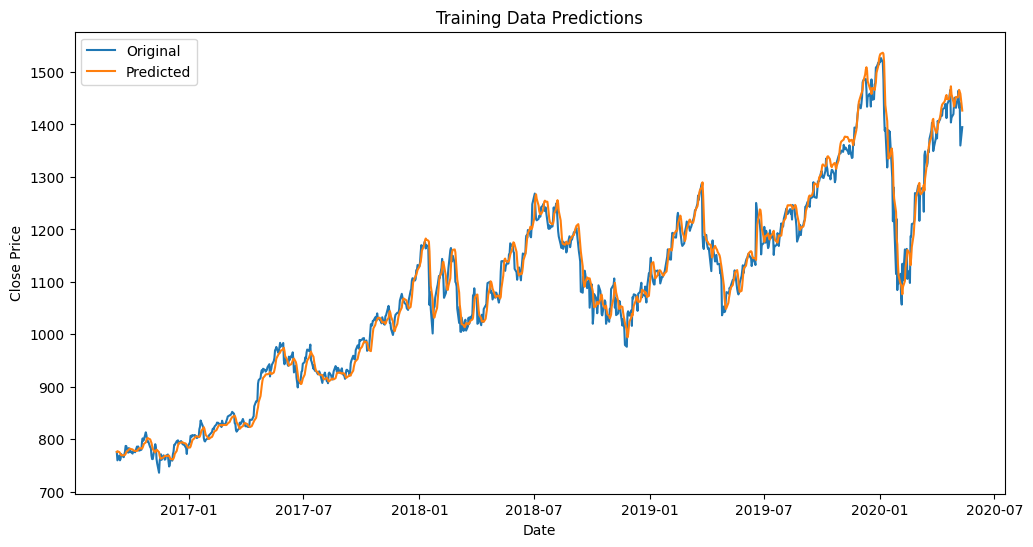

In [ ]:
# Plot training data predictions
plt.figure(figsize=(12, 6))
plt.plot(sliding_window_df.index[:split_index], Y_train_inv, label='Original')
plt.plot(sliding_window_df.index[:split_index], train_predictions_inv, label='Predicted')
plt.title('Training Data Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# Reverse scaling for validation data predictions
Y_val_inv = scaler_Y.inverse_transform(Y_val.reshape(-1, 1)).flatten()
val_predictions = model.predict(X_val).flatten()
val_predictions_inv = scaler_Y.inverse_transform(val_predictions.reshape(-1, 1)).flatten()


8/8 [==============================] - 0s 16ms/step


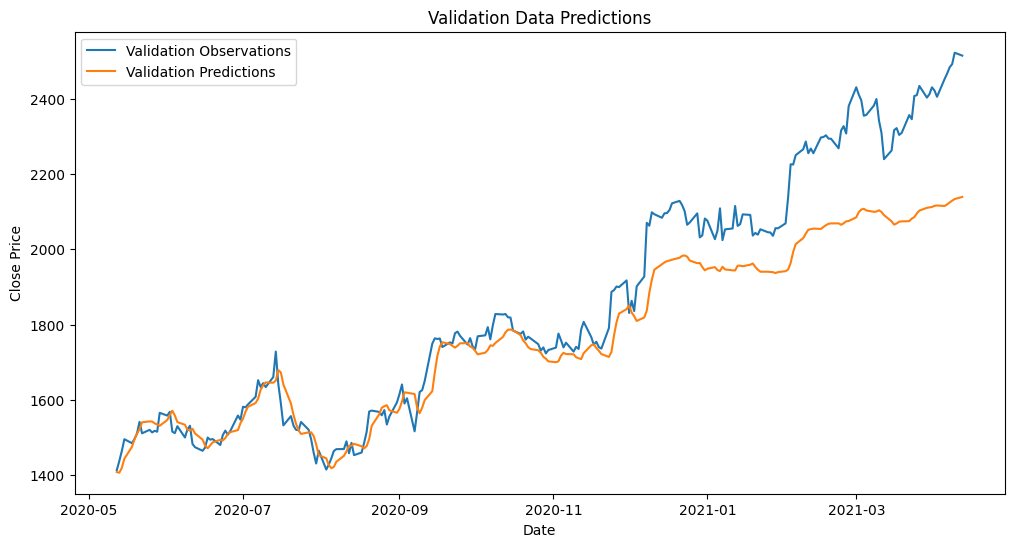

In [ ]:
# Plot validation data predictions
plt.figure(figsize=(12, 6))
plt.plot(sliding_window_df.index[split_index:], Y_val_inv, label='Validation Observations')
plt.plot(sliding_window_df.index[split_index:], val_predictions_inv, label='Validation Predictions')
plt.title('Validation Data Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
